https://www.kaggle.com/donniedarko/darktaxi-tripdurationprediction-lb-0-385#Feature-Extraction

In [1]:
import sklearn
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns

In [59]:
TRAIN_PATH='../input/train.csv'
TEST_PATH='../input/test.csv'
SAMPLE_PATH='../input/sample_submission.csv'

In [60]:
train=pd.read_csv(TRAIN_PATH)
test=pd.read_csv(TEST_PATH)
sample=pd.read_csv(SAMPLE_PATH)

In [61]:
train_num=train.shape[0]
df_all=pd.concat([train,test])

In [62]:
df_all['pickup_datetime']=df_all['pickup_datetime'].apply(pd.Timestamp)
df_all['dropoff_datetime']=df_all['dropoff_datetime'].apply(pd.Timestamp)


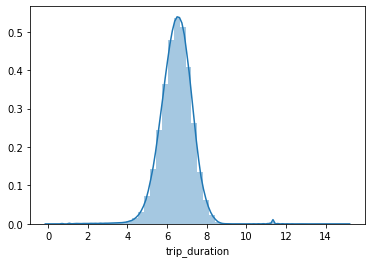

In [11]:
sns.distplot(np.log(train['trip_duration']))

In [63]:
df_all['trip_duration_log']=np.log(df_all['trip_duration'])

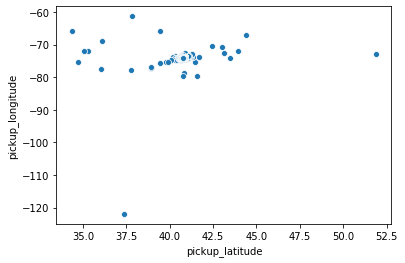

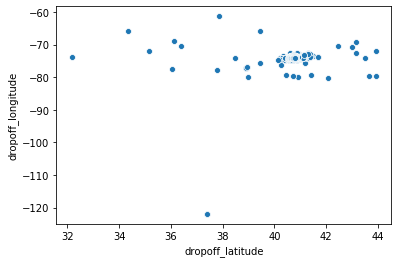

In [18]:
sns.scatterplot(x='pickup_latitude',y='pickup_longitude',data=train)
plt.show()
sns.scatterplot(x='dropoff_latitude',y='dropoff_longitude',data=train)
plt.show()

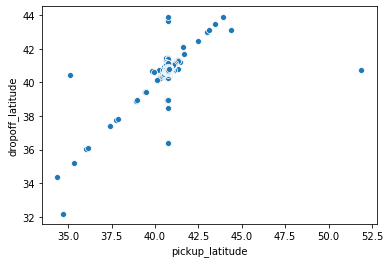

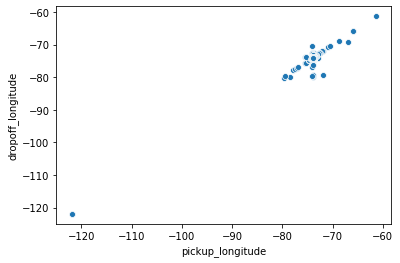

In [19]:
sns.scatterplot(x='pickup_latitude',y='dropoff_latitude',data=train)
plt.show()
sns.scatterplot(x='pickup_longitude',y='dropoff_longitude',data=train)
plt.show()

In [64]:
from sklearn.decomposition import PCA
X=np.vstack((df_all[['pickup_latitude','pickup_longitude']],df_all[['dropoff_latitude','dropoff_longitude']]))
min_lat,min_lng=X.mean(axis=0)-X.std(axis=0)
max_lat,max_lng=X.mean(axis=0)+X.std(axis=0)
X=X[(X[:,0]>min_lat) & (X[:,0]<max_lat) & (X[:,1]>min_lng) & (X[:,1]<max_lng)]

In [65]:
pca = PCA().fit(X)
X_pca = pca.transform(X)

Text(0.5, 1.0, 'Rotated')

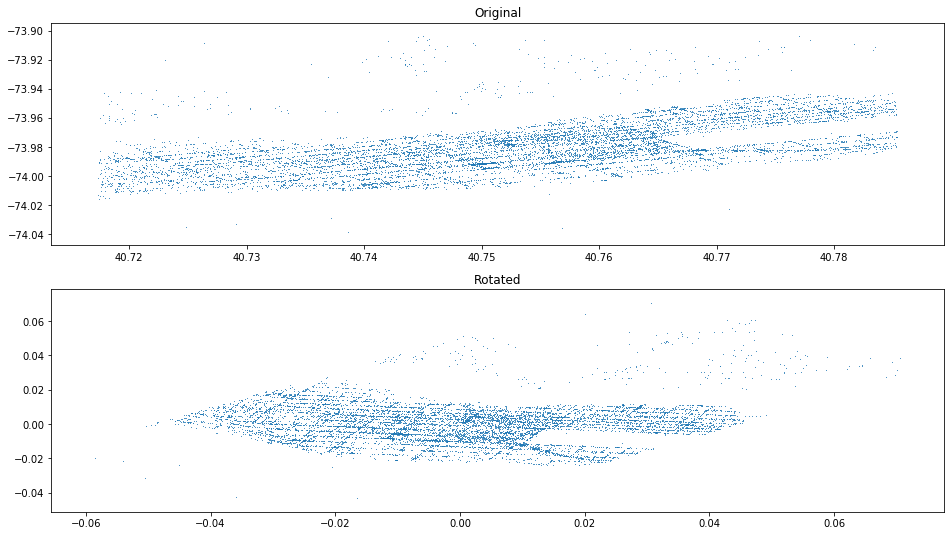

In [66]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

sample_ind = np.random.permutation(len(X))[:10000]

ax1.scatter(X[sample_ind,0], X[sample_ind,1], s=1, lw=0)
ax1.set_title('Original')

ax2.scatter(X_pca[sample_ind,0], X_pca[sample_ind,1], s=1, lw=0)
ax2.set_title('Rotated')

In [67]:
df_all['pickup_pca0']=pca.transform(df_all[['pickup_latitude','pickup_longitude']])[:,0]
df_all['pickup_pca1']=pca.transform(df_all[['pickup_latitude','pickup_longitude']])[:,1]
df_all['dropoff_pca0']=pca.transform(df_all[['dropoff_latitude','dropoff_longitude']])[:,0]
df_all['dropoff_pca1']=pca.transform(df_all[['dropoff_latitude','dropoff_longitude']])[:,1]

In [68]:
df_all['pca_manhattan'] = \
    (df_all['dropoff_pca0'] - df_all['pickup_pca0']).abs() + \
    (df_all['dropoff_pca1'] - df_all['pickup_pca1']).abs()

In [69]:
def arrays_haversine(lats1, lngs1, lats2, lngs2, R=6371):
    lats1_rads = np.radians(lats1)
    lats2_rads = np.radians(lats2)
    lats_delta_rads = np.radians(lats2 - lats1)
    lngs_delta_rads = np.radians(lngs2 - lngs1)
    
    a = np.sin(lats_delta_rads / 2)**2 + np.cos(lats1) * np.cos(lats2) * np.sin(lngs_delta_rads / 2)**2
    c = 2 * np.arcsin(a**0.5)
    
    return R * c

In [70]:
df_all['haversine'] = arrays_haversine(
    df_all['pickup_latitude'], df_all['pickup_longitude'], 
    df_all['dropoff_latitude'], df_all['dropoff_longitude'])

In [71]:
# 緯度と経度から距離を求める
def arrays_bearing(lats1, lngs1, lats2, lngs2, R=6371):
    lats1_rads = np.radians(lats1)
    lats2_rads = np.radians(lats2)
    lngs1_rads = np.radians(lngs1)
    lngs2_rads = np.radians(lngs2)
    lngs_delta_rads = np.radians(lngs2 - lngs1)
    
    y = np.sin(lngs_delta_rads) * np.cos(lats2_rads)
    x = np.cos(lats1_rads) * np.sin(lats2_rads) - np.sin(lats1_rads) * np.cos(lats2_rads) * np.cos(lngs_delta_rads)
    
    return np.degrees(np.arctan2(y, x))

In [72]:
df_all['bearing'] = arrays_bearing(
    df_all['pickup_latitude'], df_all['pickup_longitude'], 
    df_all['dropoff_latitude'], df_all['dropoff_longitude'])

In [73]:
df_all['pickup_time_delta'] = (df_all['pickup_datetime'] - df_all['pickup_datetime'].min()).dt.total_seconds()

In [74]:
df_all['month']=df_all['pickup_datetime'].dt.month
df_all['weekofyear']=df_all['pickup_datetime'].dt.weekofyear
df_all['weekday']=df_all['pickup_datetime'].dt.weekday
df_all['hour']=df_all['pickup_datetime'].dt.hour
df_all.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,...,dropoff_pca0,dropoff_pca1,pca_manhattan,haversine,bearing,pickup_time_delta,month,weekofyear,weekday,hour
0,2016-03-14 17:32:30,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,N,455.0,...,0.020013,0.002733,0.024721,1.960597,99.970196,6369878.0,3,11,0,17
1,2016-06-12 00:54:38,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,N,663.0,...,-0.028978,0.001573,0.027147,2.263525,-117.153768,14085798.0,6,23,6,0
2,2016-01-19 12:10:48,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,N,2124.0,...,-0.048200,0.011988,0.075480,6.656988,-159.680165,1596907.0,1,3,1,11
3,2016-04-06 19:39:40,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,N,429.0,...,-0.055439,0.009335,0.018682,1.493928,-172.737700,8364734.0,4,14,2,19
4,2016-03-26 13:38:10,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,N,435.0,...,0.026430,-0.014982,0.015117,1.188626,179.473585,7392638.0,3,12,5,13


In [75]:
df_all['week_delta'] = df_all['pickup_datetime'].dt.weekday + ((df_all['pickup_datetime'].dt.hour + (df_all['pickup_datetime'].dt.minute / 60.0)) / 24.0)

In [76]:
# Make time features cyclic
df_all['week_delta_sin'] = np.sin((df_all['week_delta'] / 7) * np.pi)**2
df_all['hour_sin'] = np.sin((df_all['hour'] / 24) * np.pi)**2

In [77]:
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling('60min').count()['id']
df_all = df_all.merge(df_counts, on='id', how='left')

In [78]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=8**2, batch_size=32**3).fit(X)

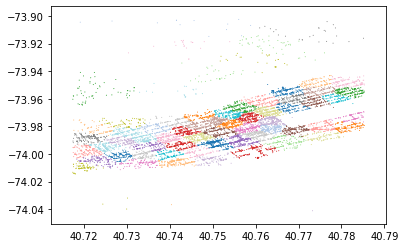

In [79]:
sample_ind = np.random.permutation(len(X))[:10000]
plt.scatter(X[sample_ind,0], X[sample_ind,1], s=1, lw=0, 
            c=kmeans.predict(X[sample_ind]), cmap='tab20')

In [80]:
df_all['pickup_cluster'] = kmeans.predict(df_all[['pickup_latitude', 'pickup_longitude']])
df_all['dropoff_cluster'] = kmeans.predict(df_all[['dropoff_latitude', 'dropoff_longitude']])

In [81]:
# Count how many trips are going to each cluster over time
group_freq = '60min'

df_dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})
    
df_all['pickup_datetime_group'] = df_all['pickup_datetime'].dt.round(group_freq)

df_all['dropoff_cluster_count'] = \
    df_all[['pickup_datetime_group', 'dropoff_cluster']].merge(df_dropoff_counts, 
        on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

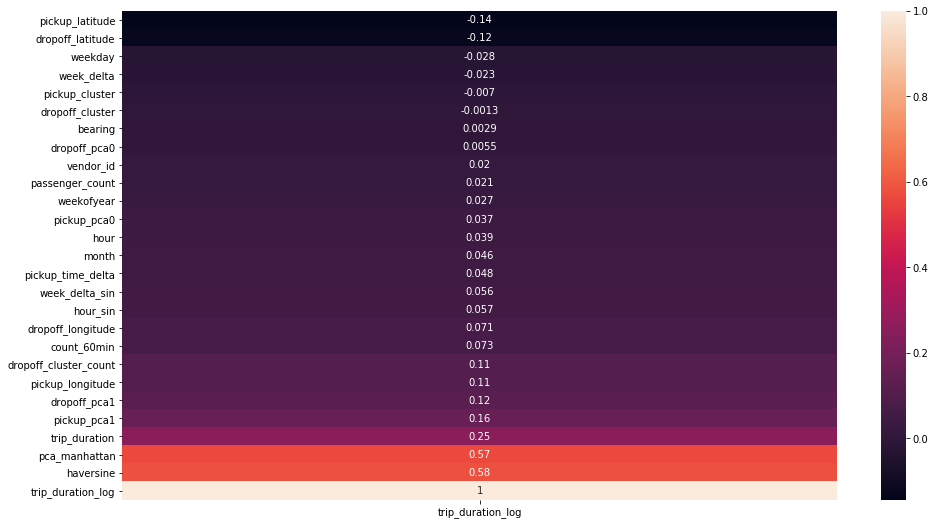

In [82]:
plt.figure(figsize=(16,9))
sns.heatmap(df_all.corr()[['trip_duration_log']].sort_values('trip_duration_log'), annot=True)

In [83]:
features = [
    'vendor_id', 'passenger_count',
    'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
    'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1',
    'haversine', 'bearing', 'pca_manhattan',
    'pickup_time_delta', 'month', 'weekofyear', 'weekday', 'hour', 
    'week_delta', 'week_delta_sin', 'hour_sin',
    'count_60min', 'dropoff_cluster_count'
]

In [85]:
df_all[features].dtypes

vendor_id                  int64
passenger_count            int64
pickup_latitude          float64
pickup_longitude         float64
dropoff_latitude         float64
dropoff_longitude        float64
pickup_pca0              float64
pickup_pca1              float64
dropoff_pca0             float64
dropoff_pca1             float64
haversine                float64
bearing                  float64
pca_manhattan            float64
pickup_time_delta        float64
month                      int64
weekofyear                 int64
weekday                    int64
hour                       int64
week_delta               float64
week_delta_sin           float64
hour_sin                 float64
count_60min              float64
dropoff_cluster_count    float64
dtype: object

In [95]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
X_train=df_all[df_all['trip_duration'].notnull()][features].values
X_test=df_all[df_all['trip_duration'].isnull()][features].values
y_train=df_all[df_all['trip_duration'].notnull()]['trip_duration_log'].values

In [96]:
xgb = XGBRegressor(n_estimators=1000, max_depth=12, min_child_weight=150, 
                   subsample=0.7, colsample_bytree=0.3)

y_test = np.zeros(len(X_test))

for i, (train_ind, val_ind) in enumerate(KFold(n_splits=2, shuffle=True, 
                                               random_state=1989).split(X_train)):
    print('----------------------')
    print('Training model #%d' % i)
    print('----------------------')
    
    xgb.fit(X_train[train_ind], y_train[train_ind],
            eval_set=[(X_train[val_ind], y_train[val_ind])],
            early_stopping_rounds=10, verbose=25)
    
    y_test += xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)
    
y_test /= 2


----------------------
Training model #0
----------------------
[14:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.41919
Will train until validation_0-rmse hasn't improved in 10 rounds.
[25]	validation_0-rmse:0.583689
[50]	validation_0-rmse:0.401626
[75]	validation_0-rmse:0.391511
[100]	validation_0-rmse:0.388282
[125]	validation_0-rmse:0.386664
[150]	validation_0-rmse:0.385321
[175]	validation_0-rmse:0.384831
[200]	validation_0-rmse:0.384353
[225]	validation_0-rmse:0.384055
[250]	validation_0-rmse:0.383885
Stopping. Best iteration:
[244]	validation_0-rmse:0.383873

----------------------
Training model #1
----------------------
[14:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.42106
Will train until validation_0-rmse hasn't improved in 10 rounds.
[25]	validation_0-rmse:0.585042
[50]	vali

In [99]:
df_sub = pd.DataFrame({
    'id': df_all[df_all['trip_duration'].isnull()]['id'].values,
    'trip_duration': np.exp(y_test)}).set_index('id')
df_sub.to_csv('xgb_feature2_submission.csv')

グリッドサーチ
https://www.kaggle.com/omarito/gridsearchcv-xgbregressor-0-556-lb

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

xgb = XGBRegressor(nthread=-1)
random_search = GridSearchCV(xgb,param_grid=params)
random_search.fit(X_train, y_train)

[15:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[16:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:58:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
y_test=random_search.predict(X_test)
df_sub = pd.DataFrame({
    'id': df_all[df_all['trip_duration'].isnull()]['id'].values,
    'trip_duration': np.exp(y_test)}).set_index('id')
df_sub.to_csv('xgb_grid_feature2_submission.csv')